# 작성자: 이종은

# 데이터 준비

In [1]:
!kaggle competitions download -c facebook-recruiting-iv-human-or-bot

  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 82.7MB/s]
 95% 235M/248M [00:02<00:00, 142MB/s]
100% 248M/248M [00:02<00:00, 115MB/s]
  0% 0.00/193k [00:00<?, ?B/s]
100% 193k/193k [00:00<00:00, 139MB/s]
  0% 0.00/115k [00:00<?, ?B/s]
100% 115k/115k [00:00<00:00, 99.7MB/s]


# 라이브러리

In [2]:
pip install beautifultable

In [ ]:
import pandas as pd
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from beautifultable import BeautifulTable

import warnings

# 피쳐 엔지니어링
import time
import datetime
import scipy
import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams
from sklearn import metrics

from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# 그레디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier

# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### bids.csv, train.csv, test.csv, sampleSubmission.csv가 주어짐

## bids 데이터셋은 입찰에 대한 정보가 담겨 있다.


In [ ]:
bids = pd.read_csv("bids.csv")
bids.head(5)
# bid는 입찰
# auction은 경매
# 한 경매 안에 입찰이 여러 개 있을 수 있음.

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


## train 데이터셋은 입찰자에 대한 정보가 담겨 있다.

In [ ]:
train = pd.read_csv("train.csv")
train.head(5)

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [ ]:
train.shape

(2013, 4)

In [ ]:
bids.shape

(7656334, 9)

# 데이터 전처리

In [ ]:
bid = pd.merge(train, bids, on='bidder_id', how='left')
# 정보를 이용하여 target인 outcome을 다루려면
# 일단 두 데이터셋의 merge가 필요하다.
# 두 데이터셋에 동일하게 있는 bidder_id를 기준으로 merge 했다.

In [ ]:
bid.to_csv("bid.csv")

In [ ]:
data = pd.read_csv("bid.csv")
data.head(7)

,Unnamed: 0,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url
0,0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3
1,1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3
2,2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3
3,3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3
4,4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3
5,5,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,666164.0,1m5t8,home goods,phone35,9.763163e+15,ke,192.145.217.243,vasstdc27m7nks3
6,6,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,700546.0,0xo1d,home goods,phone4,9.763386e+15,et,223.233.166.93,vasstdc27m7nks3


In [ ]:
data.shape

(3071253, 13)

In [ ]:
data["outcome"].value_counts()

0.0    2658837
1.0     412416
Name: outcome, dtype: int64

In [ ]:
pd.isnull(data).any()
# True -> 결측치가 있다.
# 결측치가 bids 데이터셋에서만 있는 것을 확인 할 수 있다.

Unnamed: 0         False
bidder_id          False
payment_account    False
address            False
outcome            False
bid_id              True
auction             True
merchandise         True
device              True
time                True
country             True
ip                  True
url                 True
dtype: bool

In [ ]:
nobids_train = data[pd.isnull(data['bid_id'])]['bidder_id'].unique()
len(nobids_train)
# 입찰 기록이 없는(관련 bids 데이터가 없는) bidder_id를 찾아본다.

29

In [ ]:
data[data['bidder_id'].isin(nobids_train)]['outcome']
# 입찰 기록이 없는 29명의 bidder들은 모두 0(human)으로 labeling 돼 있다.

17583      0.0
42424      0.0
129439     0.0
214915     0.0
221776     0.0
226432     0.0
255107     0.0
305088     0.0
333331     0.0
409451     0.0
654549     0.0
657208     0.0
788183     0.0
790914     0.0
794927     0.0
810369     0.0
883351     0.0
1018748    0.0
1019599    0.0
1021349    0.0
1123023    0.0
1139921    0.0
1217466    0.0
1465813    0.0
1482542    0.0
1648201    0.0
1974826    0.0
2139077    0.0
2999380    0.0
Name: outcome, dtype: float64

In [ ]:
bid = data[~data['bidder_id'].isin(nobids_train)]
# 주목하는 target인 1(robot)이 아니기에
# 해당 결측치들은 drop하는 방식으로 진행한다.

In [ ]:
pd.isnull(bid).any()
# country엔 결측치가 여전히 있다.

Unnamed: 0         False
bidder_id          False
payment_account    False
address            False
outcome            False
bid_id             False
auction            False
merchandise        False
device             False
time               False
country             True
ip                 False
url                False
dtype: bool

In [ ]:
count_miss_ratio = pd.isnull(bid['country']).sum()/len(bid)*100
print("%0.2f%%의 관측치가 country 항목에서 결측치로 확인됨." % float(count_miss_ratio))

0.09%의 관측치가 country 항목에서 결측치로 확인됨.


In [ ]:
bid = bid.dropna()
# 결측치가 데이터에서 큰 비중을 차지하면
# drop 대신 imputation 해야하지만
# 0.09 퍼센트 정도의 결측치는 drop 해도 무방하다.

In [ ]:
pd.isnull(bid).any()
# 이제 결측치가 없다.

Unnamed: 0         False
bidder_id          False
payment_account    False
address            False
outcome            False
bid_id             False
auction            False
merchandise        False
device             False
time               False
country            False
ip                 False
url                False
dtype: bool

# 데이터 탐색

In [ ]:
print(f"행의 수:          {len(bid)}")
print(f"입찰 수:          {len(bid['bid_id'].unique())}")
print(f"경매자 수:        {len(bid['bidder_id'].unique())}")
print(f"지불 수:          {len(bid['payment_account'].unique())}")
print(f"주소 수:          {len(bid['address'].unique())}")
print(f"경매 수:          {len(bid['auction'].unique())}")
print(f"merchandise 수:   {len(bid['merchandise'].unique())}")
print(f"device 수:        {len(bid['device'].unique())}")
print(f"국적 수:          {len(bid['country'].unique())}")
print(f"IP 수:            {len(bid['ip'].unique())}")
print(f"URL 수:           {len(bid['url'].unique())}")

행의 수:          3068523
입찰 수:          3068523
경매자 수:        1983
지불 수:          1983
주소 수:          1983
경매 수:          12740
merchandise 수:   10
device 수:        5726
국적 수:          198
IP 수:            1028810
URL 수:           663265


In [ ]:
bid['merchandise'].unique()

array(['home goods', 'office equipment', 'sporting goods',
       'books and music', 'mobile', 'jewelry', 'computers', 'clothing',
       'furniture', 'auto parts'], dtype=object)

In [ ]:
print(
    f"로봇이 입찰한 수: {len(bid[bid['outcome'] == 1])}")
print(
    f"사람이 입찰한 수:  {len(bid[bid['outcome'] == 0])}")
print(f"로봇 입찰 수: 사람 입찰 수 = 1 : 6.45")
# 클래스 불균형이 있는 것으로 보이며
# 모델을 훈련시키기 전에 리샘플링해야 한다.
# ex) 수가 많은 class를 undersampling 한다든지
# ex) 수가 적은 class를 oversampling 한다든지 

로봇이 입찰한 수: 412153
사람이 입찰한 수:  2656370
로봇 입찰 수: 사람 입찰 수 = 1 : 6.45


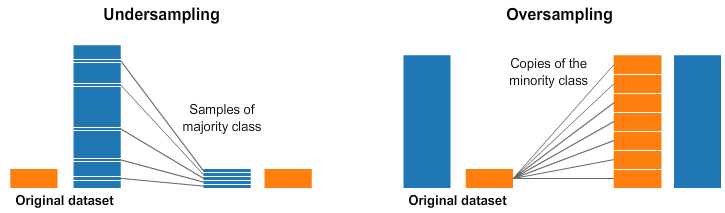

In [ ]:
412153/(412153+2656370)*100/13.43164121631156

1.0

In [ ]:
2656370/(412153+2656370)*100/13.43164121631156

6.445106550237412

In [ ]:
print(f"average bids per robot: %.0f" % float(len(
    bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['bidder_id'].unique())))
print(f"average bids per human:  %.0f" % float(len(
    bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['bidder_id'].unique())))
print(f"average bids per auction by robot: %.0f" % float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['auction'].unique())))
print(f"average bids per auction by human:  %.0f" % float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['auction'].unique())))
print(f"average bids per device by robot: %.0f" % float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['device'].unique())))
print(f"average bids per device by human:  %.0f" % float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['device'].unique())))
print(f"average bids per ip by robots: %.2f" % float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['ip'].unique())))
print(f"average bids per ip by human:  %.2f" % float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['ip'].unique())))
print(f"average bids per url by robot: %.2f" % float(
    len(bid[bid['outcome'] == 1])/len(bid[bid['outcome'] == 1]['url'].unique())))
print(f"average bids per url by human:  %.2f" % float(
    len(bid[bid['outcome'] == 0])/len(bid[bid['outcome'] == 0]['url'].unique())))

# 입찰 수 자체는 robot이 적었지만
# 로봇 하나의 평균 입찰 수는 인간 한 명의 평균 입찰 수의 두, 세 배 정도다.
# 로봇이 참여한 경매당 평균 입찰 수와 device당 평균 입찰 수는 인간보다 적고
# 사용 IP당 입찰 수도 로봇이 인간보다 적다.
# URL당 평균 입찰 수는 로봇이 인간보다 많다.
# 후술하겠지만, 로봇이 다른 IP를 통해 입찰에 참여하려 하고
# 입찰에 참여할 때마다 랜덤한 URL이 아닌 특정 URL로 참여함을 알 수 있다.

average bids per robot: 4001
average bids per human:  1413
average bids per auction by robot: 64
average bids per auction by human:  217
average bids per device by robot: 134
average bids per device by human:  516
average bids per ip by robots: 1.79
average bids per ip by human:  3.19
average bids per url by robot: 7.52
average bids per url by human:  4.36


# Feature Engineering

In [ ]:
# 엔트로피를 구하는 함수. # 엔트로피 값이 크면 불확실성이 큼.
def ent(data):
    p_data = data.value_counts()/len(data)
    entropy = scipy.stats.entropy(p_data)
    return entropy

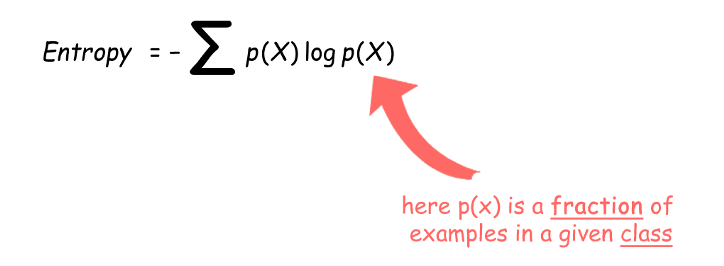

In [ ]:
# bidding time difference per user (bidder_id)
bid = bid.sort_values(by=['time'])
bid['timediffs'] = bid.groupby('bidder_id')['time'].transform(pd.Series.diff)

# number of bids a user made per auction
bids_per_auction = bid.groupby(['auction', 'bidder_id']).size()
bids_per_auction = bids_per_auction.to_frame()

# proportion of bots for each country
pbots_country = bid[bid['outcome'] == 1].groupby(
    'country').size()/bid.groupby('country').size()
pbots_country = pbots_country.fillna(0)
pbots_country = pbots_country.to_frame()

# proportion of bots per device
pbots_device = bid[bid['outcome'] == 1].groupby(
    'device').size()/bid.groupby('device').size()
pbots_device = pbots_device.fillna(0)
pbots_device = pbots_device.to_frame()

# number of unique ip to number of bids ratio
ip_bids_ratio = bid.groupby('bidder_id')['ip'].nunique(
)/bid.groupby('bidder_id')['bid_id'].nunique()
ip_bids_ratio = ip_bids_ratio.to_frame()

# mean per auction url entropy for each user
# Input a pandas series
auction_url_entropy = bid.groupby(['auction', 'bidder_id'])['url'].apply(ent)
auction_url_entropy = auction_url_entropy.groupby(
    'bidder_id').mean().reset_index()

In [ ]:
# merge the features back
bid = pd.merge(bid, bids_per_auction, on=['auction', 'bidder_id'], how='left')
bid = pd.merge(bid, pbots_country, on='country', how='left')
bid = pd.merge(bid, pbots_device, on='device', how='left')
bid = pd.merge(bid, ip_bids_ratio, on='bidder_id', how='left')
bid = pd.merge(bid, auction_url_entropy, on='bidder_id', how='left')
# set column names
bid.columns = ['Unnamed: 0', 'bidder_id', 'payment_account', 'address', 'outcome',
               'bid_id', 'auction', 'merchandise', 'device', 'time', 'country',
               'ip', 'url', 'timediffs', 'bids_per_auction', 'pbots_country', 'pbots_device',
               'ip_bids_ratio', 'auction_url_entropy']

In [ ]:
bid.head(10)

,Unnamed: 0,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,255212,76218e14c379c12d599dae9e1c00b61a3i5b2,a3d2de7675556553a5f08e4c88d2c228sjo4q,ca8d4b018cb62966eebb2974f5a83b4fstk6z,0.0,2351187.0,6hpvy,sporting goods,phone1161,9.631917e+15,cz,121.169.96.51,f33fl83l4vrg6is,NaN,368,0.089199,0.020161,0.178624,1.463760
1,1021717,6e178db6d17d21aa88aaca5bf15c2761lc500,a3d2de7675556553a5f08e4c88d2c228mqaf6,0d11440b07e5e2c8550af74b728ab4edk47gk,0.0,2351200.0,jqx39,jewelry,phone99,9.631917e+15,sa,174.12.78.255,omwhmwzvrn6ycq6,NaN,15452,0.177281,0.055360,0.583490,0.885604
2,1648618,197e90906939267ace2422e78e8e83889znqp,faef6512727719c3dd147a06ba951c947c4fn,dd7151709002fc3dce968916d8ec00ede03vc,0.0,2351192.0,gst86,home goods,phone348,9.631917e+15,ma,154.151.182.60,vasstdc27m7nks3,NaN,2386,0.095494,0.065255,0.461730,0.809338
3,2193832,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351190.0,fagyq,sporting goods,phone1,9.631917e+15,in,161.192.187.34,3skc4v2r07bneta,NaN,851,0.133801,0.056095,0.196636,1.747853
4,2193831,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351188.0,64uay,sporting goods,phone0,9.631917e+15,ke,17.120.130.121,vasstdc27m7nks3,0.0,12,0.035496,0.009222,0.196636,1.747853
5,485371,3d7cff3dedd8a8e02dbc551c6a61da3bibbvh,8afafc0824f86e8af8017e037396311cqqxtb,5e0db345d781856edfdd20895e7e190dq6zs1,1.0,2351194.0,5mqsv,home goods,phone4,9.631917e+15,vn,235.207.16.31,vasstdc27m7nks3,NaN,15,0.084575,0.045936,0.327745,0.479477
6,73636,d65efaa8129a85f85bf909e5abde8c3628gfv,2981750fbed3b561685afdf5f8bd484b499cn,a3d2de7675556553a5f08e4c88d2c2282r3s6,0.0,2351193.0,i01xm,jewelry,phone13,9.631917e+15,sg,113.217.213.15,eovsi6u99d9b72w,NaN,2,0.289463,0.449766,0.531639,1.084777
7,1482543,9655ccc7c0c193f1549475f02c54dce45kjw7,a04bad750c3144125fb80a399273bfa1wi6hx,fcec7ba7b352f0a5e62ca742391e8ab3yylj7,1.0,2351211.0,jqx39,sporting goods,phone290,9.631917e+15,de,13.173.247.96,vasstdc27m7nks3,NaN,62399,0.639716,0.479100,0.691033,0.043191
8,2193833,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351204.0,4gor9,sporting goods,phone76,9.631917e+15,vn,14.194.184.32,vasstdc27m7nks3,52631578.0,781,0.084575,0.036265,0.196636,1.747853
9,150665,3a5420301c0dacbc5675f6f09aac0143tuodl,7e8765daf511e88d1e8c832db07dd7e265hp0,bd20dc70c53713a6201146da1f90d0879swuw,0.0,2351203.0,jqx39,jewelry,phone25,9.631917e+15,vn,48.186.219.240,a9oo5hbdagf0r9c,NaN,9341,0.084575,0.072771,0.640411,0.541644


In [ ]:
bid = pd.concat([bid.iloc[:, 4], bid.iloc[:, -6:]], axis=1)

In [ ]:
bid.head(10)

,outcome,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,0.0,NaN,368,0.089199,0.020161,0.178624,1.463760
1,0.0,NaN,15452,0.177281,0.055360,0.583490,0.885604
2,0.0,NaN,2386,0.095494,0.065255,0.461730,0.809338
3,0.0,NaN,851,0.133801,0.056095,0.196636,1.747853
4,0.0,0.0,12,0.035496,0.009222,0.196636,1.747853
5,1.0,NaN,15,0.084575,0.045936,0.327745,0.479477
6,0.0,NaN,2,0.289463,0.449766,0.531639,1.084777
7,1.0,NaN,62399,0.639716,0.479100,0.691033,0.043191
8,0.0,52631578.0,781,0.084575,0.036265,0.196636,1.747853
9,0.0,NaN,9341,0.084575,0.072771,0.640411,0.541644


In [ ]:
bid.to_csv("featured.csv")

In [ ]:
bid = pd.read_csv("featured.csv")
bid = bid.iloc[:, 1:8]

In [ ]:
bid.head(10)

,outcome,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,0.0,NaN,368,0.089199,0.020161,0.178624,1.463760
1,0.0,NaN,15452,0.177281,0.055360,0.583490,0.885604
2,0.0,NaN,2386,0.095494,0.065255,0.461730,0.809338
3,0.0,NaN,851,0.133801,0.056095,0.196636,1.747853
4,0.0,0.0,12,0.035496,0.009222,0.196636,1.747853
5,1.0,NaN,15,0.084575,0.045936,0.327745,0.479477
6,0.0,NaN,2,0.289463,0.449766,0.531639,1.084777
7,1.0,NaN,62399,0.639716,0.479100,0.691033,0.043191
8,0.0,52631578.0,781,0.084575,0.036265,0.196636,1.747853
9,0.0,NaN,9341,0.084575,0.072771,0.640411,0.541644


In [ ]:
warnings.filterwarnings('ignore')

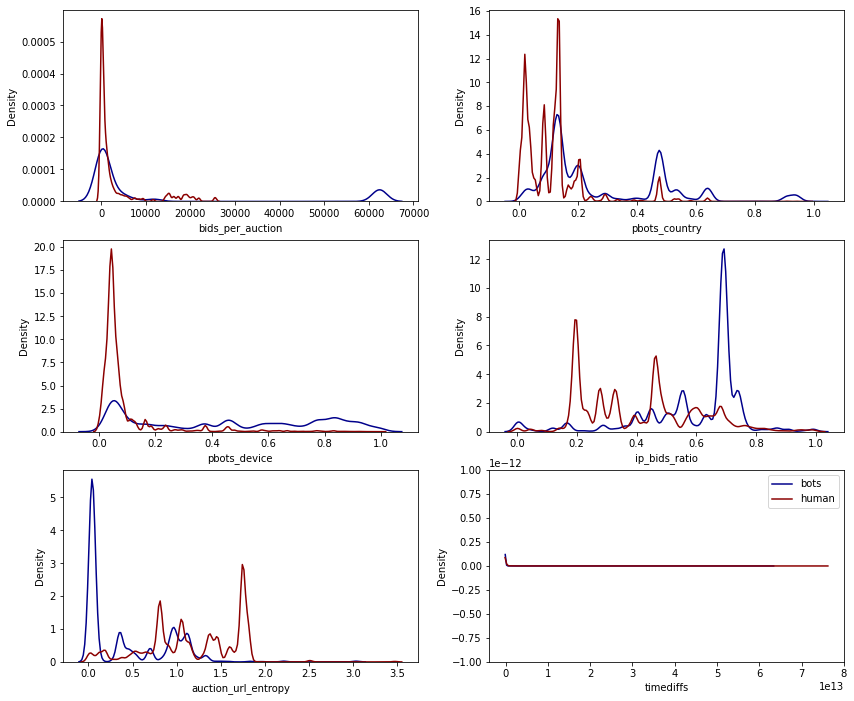

In [ ]:
bots = bid.loc[bid.outcome == 1]
human = bid.loc[bid.outcome == 0]

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
sns.distplot(bots['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])
sns.distplot(human['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])

sns.distplot(bots['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])
sns.distplot(human['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])

sns.distplot(bots['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkblue', label='bots',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])
sns.distplot(human['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkred', label='human',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])

sns.distplot(bots['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])
sns.distplot(human['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])

sns.distplot(bots['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])
sns.distplot(human['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])

sns.distplot(bots['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
sns.distplot(human['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
plt.legend(['bots', 'human'])
plt.show()

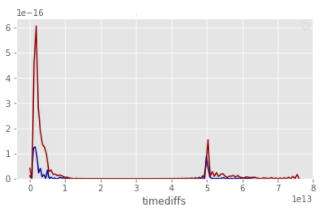

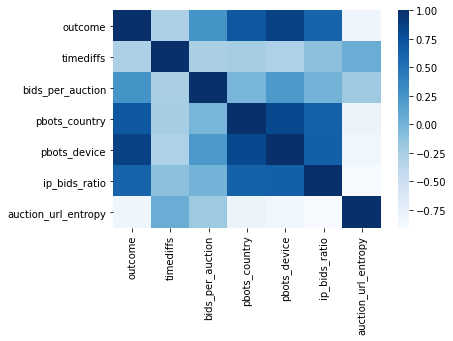

In [ ]:
# 상관관계 히트맵
corr_matrix = bid.corr()
sns.heatmap(corr_matrix.corr(),
            xticklabels=corr_matrix.corr().columns,
            yticklabels=corr_matrix.corr().columns,
            cmap="Blues",
            fmt='d')

# 클래스 불균형을 고려한 스플릿

In [ ]:
bid_train, bid_test = train_test_split(bid, test_size=0.2)

In [ ]:
# 우리는 human class에 대해 undersampling 해주겠다.
bots_train = bid_train.loc[bid_train.outcome == 1]
human_train = bid_train.loc[bid_train.outcome == 0]
human_sample = human_train.sample(n=len(bots_train))
bid_train_balance = pd.concat([bots_train, human_sample])

y_train = bid_train_balance['outcome']
X_train = bid_train_balance.iloc[:, -5:]
y_test = bid_test['outcome']
X_test = bid_test.iloc[:, -5:]

# 모델링 - DT, RF, Gradient Boosting

## 1. DT(Decision Tree)

In [ ]:
print(
    f"base model accuracy: {len(bid[bid['outcome'] == 0])/(len(bid[bid['outcome'] == 0])+len(bid[bid['outcome'] == 1])):.4f}")

base model accuracy: 0.8657


In [ ]:
dt = tree.DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(10, 15),
    'min_samples_split': range(2, 6)
}

dt_cv = GridSearchCV(estimator=dt,
                     param_grid=param_grid,
                     cv=5)
dt_cv.fit(X_train, y_train)
print(dt_cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 14, 'min_samples_split': 2}


In [ ]:
start_time = time.time()
kwargs_regularize = dict(criterion='gini',
                         max_depth=5,
                         max_leaf_nodes=14,
                         min_samples_split=2)
dt = tree.DecisionTreeClassifier(**kwargs_regularize)
dt.fit(X_train, y_train)

dt_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.636845588684082 seconds ---


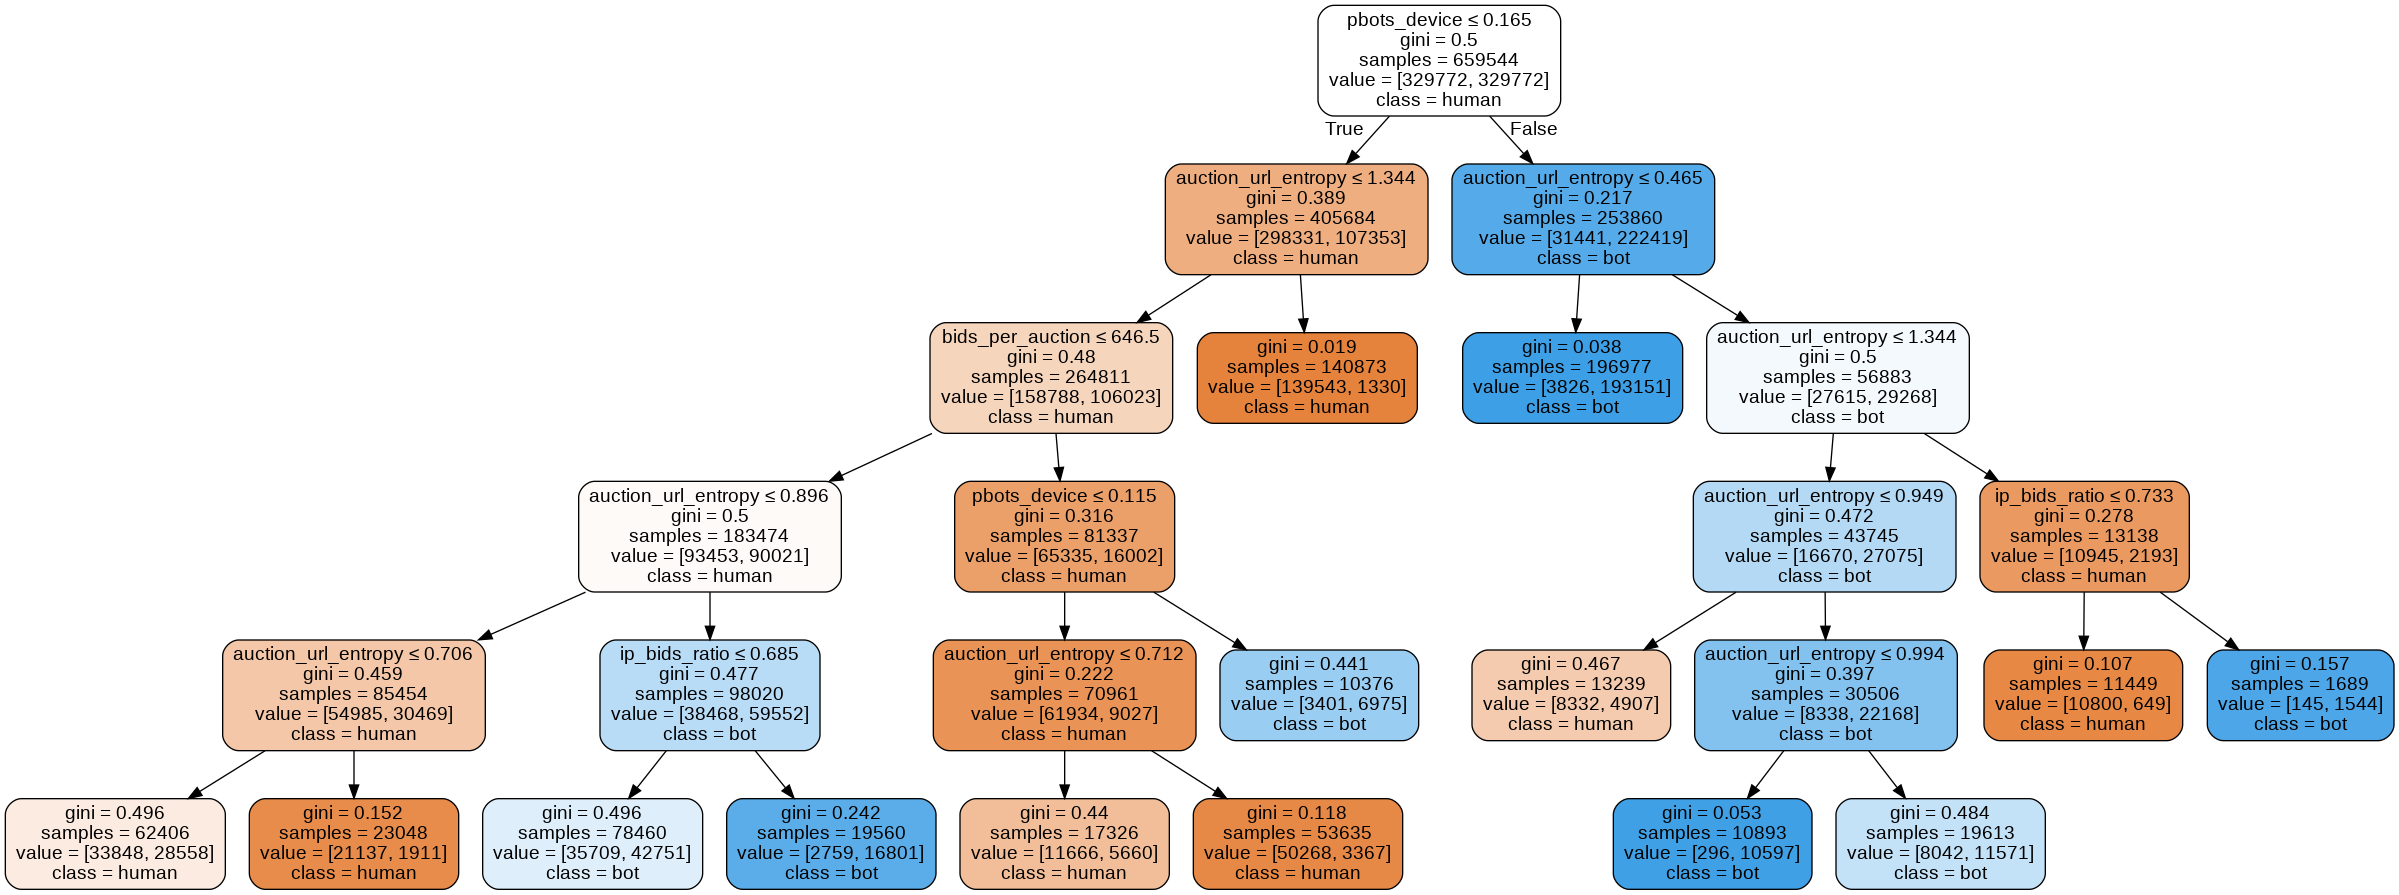

In [ ]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,
                filled=True, rounded=True,
                feature_names=X_train.columns.values,
                class_names=['human', 'bot'],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Feature importance of Decision Tree Model


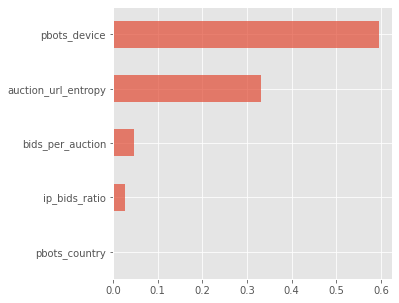

In [ ]:
print('Feature importance of Decision Tree Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)
fig.savefig('dt_feature.png')

In [ ]:
y_dt_pred = dt.predict(X_test)

In [ ]:
print(f"Decision Tree Accuracy: {accuracy_score(y_dt_pred, y_test):.3f}")

Decision Tree Accuracy: 0.840


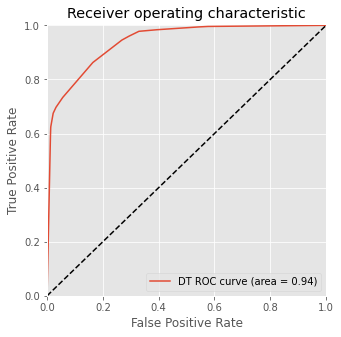

In [ ]:
y_dt_score = dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _dt = roc_curve(y_test, y_dt_score)
roc_dt_auc = auc(fpr_dt, tpr_dt)

fig = plt.figure(figsize=(5, 5))
plt.plot(fpr_dt, tpr_dt, label='DT ROC curve (area = %0.2f)' % roc_dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_dt_auc.png')

In [ ]:
print('Classification Report of Decision Tree Model')
print(classification_report(y_test, y_dt_pred))

Classification Report of Decision Tree Model
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90    531324
         1.0       0.45      0.86      0.59     82381

    accuracy                           0.84    613705
   macro avg       0.71      0.85      0.75    613705
weighted avg       0.90      0.84      0.86    613705



## 2. RF(Random Forest)

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
param_grid = {
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(8, 12),
    'max_features': ['sqrt', 'auto', 'log2']
}

rf_cv = GridSearchCV(estimator=rf,
                     param_grid=param_grid,
                     cv=5)
rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 11}


In [ ]:
start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, max_depth=5,
                            max_leaf_nodes=11, max_features='log2',
                            bootstrap=True, oob_score=True)
rf.fit(X_train, y_train)

rf_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 29.613523244857788 seconds ---


Feature importance of Random Forest Model


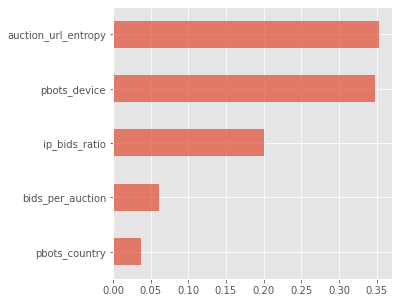

In [ ]:
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)
fig.savefig('rf_feature.png')

In [ ]:
y_rf_pred = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_rf_pred, y_test):.3f}")

Random Forest Accuracy: 0.924


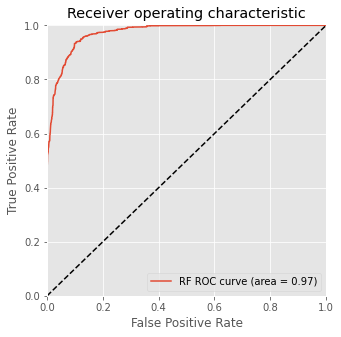

In [ ]:
y_rf_score = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _rf = roc_curve(y_test, y_rf_score)
roc_rf_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 5))
plt.plot(fpr_rf, tpr_rf, label='RF ROC curve (area = %0.2f)' % roc_rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_rf_auc.png')

In [ ]:
print('Classification Report of Random Forest Model')
print(classification_report(y_test, y_rf_pred))

Classification Report of Random Forest Model
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96    531324
         1.0       0.67      0.86      0.75     82381

    accuracy                           0.92    613705
   macro avg       0.82      0.90      0.85    613705
weighted avg       0.94      0.92      0.93    613705



## 3. GB(Gradient Boosting)

In [ ]:
gb = GradientBoostingClassifier(n_estimators=10)
param_grid = {
    'max_depth': range(3, 6),
    'max_leaf_nodes': range(8, 11)
}

gb_cv = GridSearchCV(estimator=gb,
                     param_grid=param_grid,
                     cv=5)
gb_cv.fit(X_train, y_train)
print(gb_cv.best_params_)

{'max_depth': 5, 'max_leaf_nodes': 10}


In [ ]:
start_time = time.time()

gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, max_features='sqrt',
                                max_leaf_nodes=9)
gb.fit(X_train, y_train)

gb_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 38.91479301452637 seconds ---


Feature importance of Gradient Boosting Model


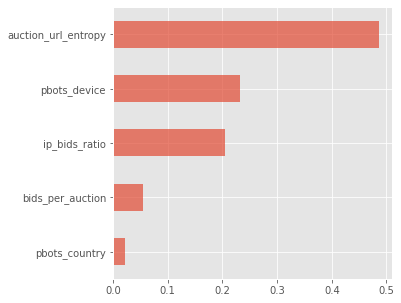

In [ ]:
print('Feature importance of Gradient Boosting Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh', alpha=0.7)
fig.savefig('gb_feature.png')

In [ ]:
y_gb_pred = gb.predict(X_test)
print(f"Gradient Boosting Accuracy: {accuracy_score(y_gb_pred, y_test):.3f}")

Gradient Boosting Accuracy: 0.976


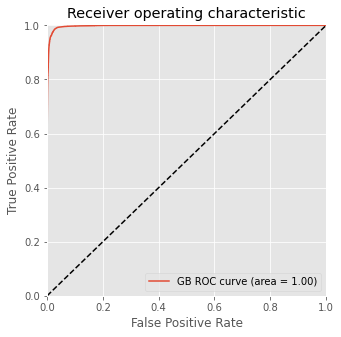

In [ ]:
y_gb_score = gb.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _gb = roc_curve(y_test, y_gb_score)
roc_gb_auc = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(5, 5))
plt.plot(fpr_gb, tpr_gb, label='GB ROC curve (area = %0.2f)' % roc_gb_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_gb_auc.png')

In [ ]:
print('Classification Report of Gradient Boosting Model')
print(classification_report(y_test, y_gb_pred))

Classification Report of Gradient Boosting Model
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    531324
         1.0       0.86      0.98      0.92     82381

    accuracy                           0.98    613705
   macro avg       0.93      0.98      0.95    613705
weighted avg       0.98      0.98      0.98    613705



# 모델 비교

In [ ]:
dt_metrics = [metrics.accuracy_score(y_test, y_dt_pred), metrics.precision_score(y_test, y_dt_pred),
              metrics.recall_score(y_test, y_dt_pred), metrics.f1_score(
                  y_test, y_dt_pred),
              metrics.roc_auc_score(y_test, y_dt_pred), dt_time]
rf_metrics = [metrics.accuracy_score(y_test, y_rf_pred), metrics.precision_score(y_test, y_rf_pred),
              metrics.recall_score(y_test, y_rf_pred), metrics.f1_score(
                  y_test, y_rf_pred),
              metrics.roc_auc_score(y_test, y_rf_pred), rf_time]
gb_metrics = [metrics.accuracy_score(y_test, y_gb_pred), metrics.precision_score(y_test, y_gb_pred),
              metrics.recall_score(y_test, y_gb_pred), metrics.f1_score(
                  y_test, y_gb_pred),
              metrics.roc_auc_score(y_test, y_gb_pred), gb_time]

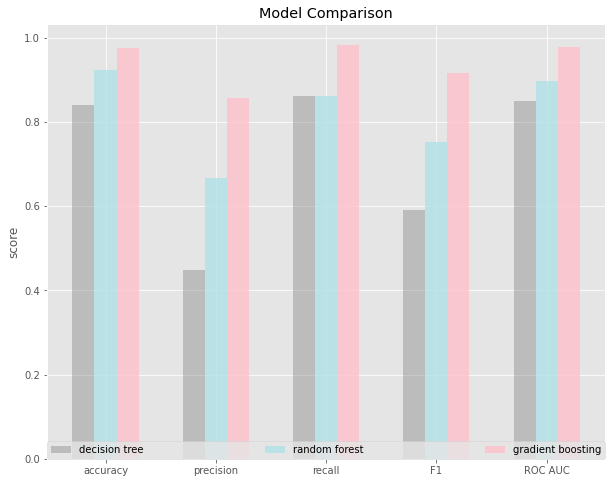

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
index = np.arange(5)
width = 0.2
b1 = plt.bar(index, dt_metrics[0:5], width,
             alpha=0.4, color='grey', label='decision tree')
b2 = plt.bar(index+width, rf_metrics[0:5], width,
             alpha=0.8, color='powderblue', label='random forest')
b3 = plt.bar(index+2*width, gb_metrics[0:5], width,
             alpha=0.8, color='pink', label='gradient boosting')
plt.title('Model Comparison')
plt.ylabel('score')
plt.xticks(index+width, ('accuracy', 'precision', 'recall', 'F1', 'ROC AUC'))
plt.legend(loc=8, ncol=3, mode="expand", borderaxespad=0.)
plt.show()
fig.savefig('model_comparison.png')

In [ ]:
label = ["Accuracy_score", "Precision_score",
         "Recall_Score", "F1_score", "ROC_AUC_score", "Time(s)"]
table = pd.DataFrame({'Decision Tree': dt_metrics,
                      'Random Forest': rf_metrics, 'Gradient Boosting': gb_metrics})
table = table.transpose()
table.columns = label
table.transpose().round(3)

,Decision Tree,Random Forest,Gradient Boosting
Accuracy_score,0.840,0.924,0.976
Precision_score,0.449,0.668,0.857
Recall_Score,0.863,0.862,0.984
F1_score,0.591,0.753,0.916
ROC_AUC_score,0.849,0.898,0.979
Time(s),0.637,29.613,38.915
